<a href="https://colab.research.google.com/github/Ashu-00/AutoEncodersAndGenerators/blob/main/Variational_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
class VAE(nn.Module):
  def __init__(self,insize=28*28, latent_size=200):
    super().__init__()

    self.h=latent_size
    self.ins=insize

    self.encoder = nn.Sequential(
        nn.Linear(self.ins,512),
        nn.LeakyReLU(),
        nn.Linear(512,400),
        nn.LeakyReLU(),

    )

    self.mumake=nn.Linear(400, self.h)
    self.varmake=nn.Linear(400, self.h)

    self.decoder= nn.Sequential(
        nn.Linear(self.h,512),
        nn.LeakyReLU(),
        nn.Linear(512,self.ins),
        nn.Sigmoid(),

    )

  def reparameterize(self, mu, var):

    eps = torch.randn_like(var)
    return mu + eps * var

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)

    x=self.encoder(x)

    mu=self.mumake(x)
    lvar=self.varmake(x)

    z=self.reparameterize(mu, lvar)


    x=self.decoder(z)
    return x.view(-1,1,28,28), mu, lvar

In [ ]:
x=torch.randn(1,1,28,28)
model=VAE()
x, mu, lvar=model(x)
print(x.shape)
print(mu.shape)
print(lvar.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 200])
torch.Size([1, 200])


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
dataset=datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

In [ ]:
generator1 = torch.Generator().manual_seed(42)
trainset,testset=torch.utils.data.random_split(dataset,[.9,.1],generator=generator1)

In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=32,shuffle=False)
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')


In [ ]:
def lossfunc(realx, outx, mu,lvar):
    reproduction_loss = nn.functional.binary_cross_entropy(outx,realx, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ torch.log(lvar.pow(2)) - mu.pow(2) - lvar.pow(2))

    return reproduction_loss + KLD

In [ ]:
def train(model,train_loader,epochs=3,lr=9e-3,device="cpu"):
  model.train()
  model.to(device)
  optimizer=optim.Adam(model.parameters(),lr=lr)

  for epoch in range(epochs):
    loop=tqdm(enumerate((train_loader)))
    lossavg=0
    for (bid,(inp,lab)) in loop:
      inp=inp.to(device)

      #lab=lab.to(device)
      out,mu,sigma=model(inp)
      loss=lossfunc(inp,out,mu,sigma)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loop.set_postfix(loss=loss.item())

      lossavg+=loss.item()

    print(f"epoch:{epoch} loss:{lossavg/(len(train_loader))}")


In [ ]:

model=VAE().to(device)

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
#model=VAE().to(device)
train(model,trainloader,epochs=10,lr=5e-4,device=device)

1688it [00:17, 96.64it/s, loss=1.52e+3] 


epoch:0 loss:3355.6900009950755


1688it [00:18, 92.63it/s, loss=1.49e+3]


epoch:1 loss:3354.8387636302205


1688it [00:17, 96.34it/s, loss=1.76e+3] 


epoch:2 loss:3351.750536588696


1688it [00:17, 95.13it/s, loss=1.6e+3]


epoch:3 loss:3349.458480473378


1688it [00:18, 93.68it/s, loss=1.6e+3] 


epoch:4 loss:3344.959348994974


1688it [00:17, 95.46it/s, loss=1.7e+3]


epoch:5 loss:3343.4360541031824


1688it [00:18, 92.05it/s, loss=1.49e+3] 


epoch:6 loss:3339.2012825192996


1688it [00:17, 95.44it/s, loss=1.77e+3]


epoch:7 loss:3335.197641092454


1688it [00:18, 92.68it/s, loss=1.75e+3]


epoch:8 loss:3332.9043787373184


1688it [00:17, 95.55it/s, loss=1.82e+3]

epoch:9 loss:3330.577905880896


In [ ]:
torch.save(model.state_dict(),'model.pt')

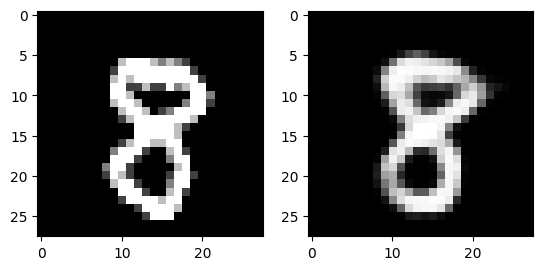

In [ ]:
model.to("cpu")
img=testset[197][0]
out,mu,sigma=model(img.unsqueeze(0))
plt.subplot(1,2,1)
plt.imshow(img.detach().cpu().squeeze(0,1),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out.detach().cpu().squeeze(0,1),cmap='gray')
plt.show()

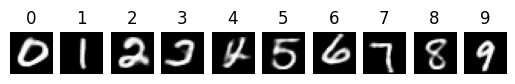

In [ ]:
def inference(dataset):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            x = model.encoder(images[d].view(1, 784))
            mu=model.mumake(x)
            sigma=model.varmake(x)


        encodings_digit.append((mu, sigma))


    for i,(mu, sigma) in enumerate(encodings_digit):
        epsilon = torch.randn_like(5*sigma)
        z = mu + sigma * epsilon
        out = model.decoder(z)
        out = out.view(-1, 1, 28, 28)
        plt.subplot(1,10,i+1)
        plt.title(f"{i}")
        plt.imshow(out.detach().cpu().squeeze(0,1),cmap='gray')
        plt.axis('off')
    plt.show()

model.to("cpu")
inference(trainset)
